### Import libraries

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from models import *
import matplotlib.pyplot as plt

### Import data

In [2]:
# read data
# df_wide = pd.read_csv('data/market_data.csv', header=[0,1], index_col=0)
df_wide = pd.read_csv('data/trade_df.csv', header=[0,1], index_col=0)

### Preprocess data (should be moved to a separate file)

In [3]:
# Convert the index to datetime (the index holds the dates)
df_wide.index = pd.to_datetime(df_wide.index)
df = df_wide.stack(level=0).reset_index()

# rename columns to have a proper
df.rename(columns={'Timestamp': 'date', 'level_1': 'ticker'}, inplace=True)

# Data Cleaning and Sorting
df.drop_duplicates(inplace=True)
df.sort_values(['ticker', 'date'], inplace=True)

# drop rows with missing values # should be moved to cleaning at some point when we start to combine datasets
df.dropna(inplace=True) # happens if there was one data point the first day of a given ticker but not the rest of the values

/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_13668/2811437911.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df_wide.stack(level=0).reset_index()


In [4]:
# 3. Create Momentum Features # should be moved to feature engineering at some point when we start to combine datasets
momentum_periods = {'mom_1m': 1, 'mom_3m': 3, 'mom_6m': 3, 'mom_12m': 12}

# compute percentage change over each period for each ticker separately.
for feature_name, period in momentum_periods.items():
    df[feature_name] = df.groupby('ticker')['Trade Close'].transform(lambda x: x.pct_change(periods=period))

# drop rows where momentum features are not defined (if desired).
df.dropna(subset=list(momentum_periods.keys()), inplace=True)


In [5]:
# define the target variable
# for testing we define the target as the next-day return.
df['target'] = df.groupby('ticker')['Trade Close'].pct_change().shift(-1)
# drop na and reset index
df.dropna(subset=['target'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
display(df)

,date,ticker,Trade Close,Trade High,Trade Low,Trade Open,Trade Volume,mom_1m,mom_3m,mom_6m,mom_12m,target
0,2002-01-31,AAB.CO,2614.683143,2771.564132,2562.389480,2614.683143,1.063991e+02,0.000000,-0.074074,-0.074074,-0.350649,0.120000
1,2002-02-28,AAB.CO,2928.445121,2928.445121,2562.389480,2719.270469,1.944595e+02,0.120000,0.076923,0.076923,-0.222222,0.125000
2,2002-03-31,AAB.CO,3294.500761,3399.088086,2928.445121,2928.445121,1.694852e+02,0.125000,0.260000,0.260000,-0.059701,-0.063492
3,2002-04-30,AAB.CO,3085.326109,3189.913435,2928.445121,3189.913435,1.992593e+02,-0.063492,0.180000,0.180000,-0.032787,-0.169492
4,2002-05-31,AAB.CO,2562.389480,2928.445121,2510.095818,2928.445121,6.842129e+01,-0.169492,-0.125000,-0.125000,-0.109091,-0.040816
...,...,...,...,...,...,...,...,...,...,...,...,...
45781,2024-10-31,ZELA.CO,790.500000,851.500000,752.000000,813.500000,3.267692e+06,-0.027675,-0.150000,-0.150000,1.699795,-0.076534
45782,2024-11-30,ZELA.CO,730.000000,893.000000,672.500000,789.500000,4.650485e+06,-0.076534,-0.176537,-0.176537,1.172619,-0.019863
45783,2024-12-31,ZELA.CO,715.500000,819.000000,587.000000,728.000000,4.138727e+06,-0.019863,-0.119926,-0.119926,0.917203,0.027952
45784,2025-01-31,ZELA.CO,735.500000,808.000000,682.500000,718.500000,3.538390e+06,0.027952,-0.069576,-0.069576,0.557603,-0.098572


### Prepare data for training

In [ ]:
feature_cols = [col for col in df.columns if col not in ['date','ticker','target']]
df_norm = df.dropna(subset=feature_cols)

# normalize inputs
X_values = df_norm[feature_cols].values.astype('float32')

# simple normalization: subtract mean, divide std
X_mean, X_std = X_values.mean(axis=0), X_values.std(axis=0)
X_values = (X_values - X_mean) / (X_std + 1e-8) # adding a small epsilon to avoid division by zero

y_values = df_norm['target'].values.astype('float32')

# train-val-test split:
# set data before 2019 as training data, 2020 as validation and data after 2020 as testing data
train_indices = df_norm['date'] < '2019-01-01'
val_indices = (df_norm['date'] >= '2019-01-01') & (df_norm['date'] < '2020-01-01')
test_indices = df_norm['date'] >= '2020-01-01'
X_train, y_train = X_values[train_indices], y_values[train_indices]
X_val, y_val = X_values[val_indices], y_values[val_indices]
X_test, y_test = X_values[test_indices], y_values[test_indices]


In [ ]:
# create dataset objects for training and validation
train_dataset = MLPdataset(X_train, y_train)
val_dataset = MLPdataset(X_val, y_val)

np.random.seed(42)
torch.manual_seed(42)

# dataloaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Train the model

In [9]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

Using device: mps


In [10]:
# hyperparameters
input_dim = X_train.shape[1]
model = MLPModel(input_dim).to(device)

# set regularization parameters
lambda_l1 = 1e-4
lambda_l2 = 1e-4

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

patience = 10
best_val_loss = float('inf')
best_model = None
epochs = 100

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model, lambda_l1)
        loss += l2_regularization(model, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).unsqueeze(1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model, lambda_l1)
            loss += l2_regularization(model, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = model
        torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5f}")
            break
    

Epoch 1/100 - Train Loss: 0.06088, Validation Loss: 0.03408
Epoch 2/100 - Train Loss: 0.04444, Validation Loss: 0.03127
Epoch 3/100 - Train Loss: 0.04188, Validation Loss: 0.02891
Epoch 4/100 - Train Loss: 0.03964, Validation Loss: 0.02691
Epoch 5/100 - Train Loss: 0.03762, Validation Loss: 0.02498
Epoch 6/100 - Train Loss: 0.03579, Validation Loss: 0.02319
Epoch 7/100 - Train Loss: 0.03416, Validation Loss: 0.02174
Epoch 8/100 - Train Loss: 0.03273, Validation Loss: 0.02034
Epoch 9/100 - Train Loss: 0.03144, Validation Loss: 0.01914
Epoch 10/100 - Train Loss: 0.03026, Validation Loss: 0.01802
Epoch 11/100 - Train Loss: 0.02918, Validation Loss: 0.01703
Epoch 12/100 - Train Loss: 0.02825, Validation Loss: 0.01611
Epoch 13/100 - Train Loss: 0.02738, Validation Loss: 0.01527
Epoch 14/100 - Train Loss: 0.02661, Validation Loss: 0.01455
Epoch 15/100 - Train Loss: 0.02590, Validation Loss: 0.01389
Epoch 16/100 - Train Loss: 0.02528, Validation Loss: 0.01329
Epoch 17/100 - Train Loss: 0.0247

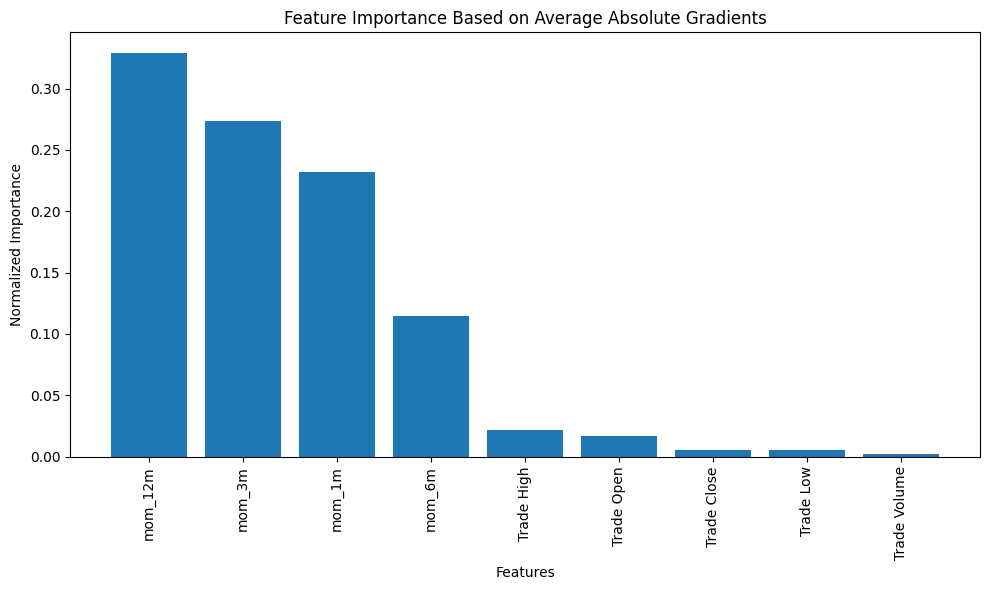

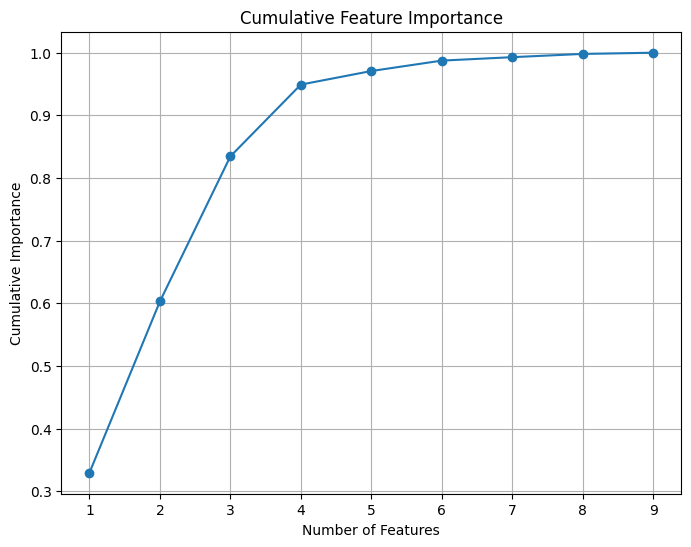

In [ ]:
# ensure the model is in evaluation mode
best_model.eval()

# initialize a tensor to accumulate importance for each feature
n_features = len(feature_cols)
feature_importance = torch.zeros(n_features).to(device)
n_samples = 0

# loop over the validation dataloader
for batch_X, batch_y in val_loader:
    batch_X = batch_X.to(device)
    # enable gradient tracking on inputs
    batch_X.requires_grad_()
    
    # forward pass
    outputs = best_model(batch_X)
    # to get a scalar output for gradient calculation, sum over the batch
    output_sum = outputs.sum()
    
    # clear previous gradients and compute gradients of the output with respect to inputs
    best_model.zero_grad()
    output_sum.backward()
    
    # accumulate the absolute gradients summed across each sample in the batch
    # (batch_X.grad has shape [batch_size, n_features])
    feature_importance += batch_X.grad.abs().sum(dim=0)
    n_samples += batch_X.size(0)

# average the gradients over all samples
feature_importance /= n_samples

# move to CPU for plotting
feature_importance = feature_importance.cpu().detach().numpy()

# normalize the importance scores to sum to 1
importance_norm = feature_importance / feature_importance.sum()

# sort features by importance in descending order
sorted_idx = np.argsort(importance_norm)[::-1]
sorted_importance = importance_norm[sorted_idx]
sorted_features = [feature_cols[i] for i in sorted_idx]

# bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importance, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance Based on Average Absolute Gradients')
plt.tight_layout()
plt.show()
